# Probing Light Fermiophobic Higgs Boson via diphoton jets at the HL-LHC

arXiv:23xx.xxxxx

by Daohan Wang, Jin-Hwan CHO, Jinheung Kim, Soojin Lee, Prasenjit Sanyal, and Jeonghyeon Song

### Requirements

- Needs at least 8G CPU memory and 8G GPU memory
- Requires the `pytorch` package (https://pytorch.org) and the `polars` package (https://www.pola.rs)
  ```
  conda install pytorch pytorch-cuda=11.8 -c pytorch -c nvidia
  conda install torchinfo tqdm -c conda-forge
  conda install "polars>=0.19"
  ```

In [1]:
import numpy as np
import polars as pl
import matplotlib.pyplot as plt

from pathlib import Path

## VI. Machine Learning Approach for Heavy $M_{H^\pm}$

In the previous two sections, we underscored the efficacy of our cut-based analysis strategy
in achieving robust significance values as well as the mass reconstruction of $m_{\gamma\gamma}$ and $M_{H^\pm}$.
Yet, challenges manifested when addressing the heavy charged Higgs boson. For instance, BP-6
reached a significance of 4.09, which is not convincing enough to confirm the presence of
the very light fermiophobic Higgs boson. Hence, in this section, we employ machine learning
techniques, with a keen focus on BP-6, BP-12, and BP-18, aiming to enhance the significances.
At the parton-level, the total cross sections for these benchmarks are $\sigma_\text{tot}(\text{BP-6}) = 9.62\,\text{fb}$,
$\sigma_\text{tot}(\text{BP-12}) = 9.63\,\text{fb}$, and $\sigma_\text{tot}(\text{BP-18}) = 9.83\,\text{fb}$.

Let us begin by discussing the preparation of input features. We formulate two distinct
features: the event feature and the subparticle feature. 

### 1. Input features

#### Event input

The event feature $\mathbf{v}_\text{event}$ comprises 21 elements, constructed as follows:

- 4 features: $\frac{1}{500} p_T^{J_1}$, $\eta_{J_1}$, $\phi_{J_1}$, $\frac{1}{500} m_{J_1}$
- 4 features: $\frac{1}{500} p_T^{J_2}$, $\eta_{J_2}$, $\phi_{J_2}$, $\frac{1}{500} m_{J_2}$
- 3 features: $\frac{1}{500} p_T^{l}$, $\eta_{l}$, $\phi_{l}$
- 2 features: $\frac{1}{500} E_T^\text{miss}$, $\phi_{\vec E_T^\text{miss}}$
- 6 features: $\Delta R_{J1,J2}$, $\Delta R_{J1,l}$, $\Delta R_{J2,l}$, $\Delta R_{J1,\vec E_T^\text{miss}}$, $\Delta R_{J2,\vec E_T^\text{miss}}$, $\Delta R_{l,\vec E_T^\text{miss}}$
- 2 features: $\frac{1}{500} M_T^{J_1}$, $\frac{1}{500} M_T^{J_2}$

Here the angular distance is defined by $\Delta R_{a,b}\equiv\sqrt{(\eta_a-\eta_b)^2+(\phi_a-\phi_b)^2}$, where $-\pi\leq \phi_a-\phi_b\leq\pi$.

The transverse mass $M_T^{J_i}$ ($i=1,2$) is defined using $p_\text{vis}^\mu=p_{J_i}^\mu+p_l^\mu$ by
$$
\bigl(M_T^{H^\pm}\bigr)^2 \equiv m_\text{vis}^2 + 2\bigl[ E_T^\text{vis} E_T^\text{miss} - \vec p_T^\text{vis}\cdot\vec E_T^\text{miss}\bigr] \tag{12}
$$
where $m_\text{vis}^2=p_\text{vis}\cdot p_\text{vis}$, $E_T^\text{vis}=\sqrt{m_\text{vis}^2+(p_T^\text{vis})^2}$, and $\vec E_T^\text{miss}=-\sum_i \vec p_T^i$ with $i$ covering all the observed particles after the pileup subtraction.

#### Subparticle input

The subparticle feature is divided into two vectors associated with $J_1$ and $J_2$. Each $J_i$
category includes the 10 leading subparticles, each characterized by three attributes:

- $\frac{1}{100} p_T$ if the subparticle is photon, otherwise 0
- $|\eta - \eta_{J_i}|$ if the subparticle is photon, otherwise 0
- $0\leq|\phi - \phi_{J_i}|\leq\pi$ if the subparticle is photon, otherwise 0

The coordinates $\eta$ and $\phi$ of a given subparticle are adjusted to be relative to their mother jet.
We divide the $p_T$ values by 100 GeV for normalization. To emphasize the photons, other particles (hadrons) are
assigned a value of zero for all three attributes.

As a result, the total dimension of the subparticle feature is $60 = 3\,\text{features} \times 2\,\text{jets} \times 10\,\text{subparticles}$.

### 2. Network architecture

Our network architecture, illustrated in Figure 11, consists of three main components: a
one-dimensional (1D) CNN block and two multilayer perceptrons (MLP1 and MLP2). The 1D
CNN block is responsible for processing the subparticle feature, whereas MLP1 handles the
event feature. MLP2 merges the outputs from both the 1D CNN and MLP1 to produce the
final model prediction.

![Figure 11](figure11.png)

Diving into the details, the 1D CNN block (`ConvNet`) comprises nine 1D convolutional layers. The first
layer (`conv0`) uses a kernel size of 3 and its output goes through a sigmoid function, which maps the
values between 0 and 1. Functioning as _attention weights_, these values are multiplied by each
subparticle input feature. This is a crucial step with a clear purpose: it assigns varying weights
to each element within the input features, thereby enhancing the model’s ability to focus on
informative parts of the data. The next eight layers (`conv1-conv8`) are also 1D convolutions with a kernel size
of 3, but they include a ReLU activation function to add non-linearity to the model. Following
these layers, an average pooling operation (`avgpool`) and a fully connected layer (`fc`) condense the information
into a 128-dimensional feature vector.

`MLP1` primarily transforms the event input feature into a 128-dimensional feature vector.
This perceptron comprises six fully connected layers (`fc1-fc6`), each containing 128 nodes. Following
each layer, batch normalization, a ReLU activation function, and a dropout layer with a 50%
probability are applied.

`MLP2` finally determins the probability that an event is classified as a signal. Its architecture
includes five fully connected layers (`MyModel.fc` and `fc1-fc3`) with node counts of 256, 256, 256, 64, and 16, in succession.
Each layer is followed by batch normalization, a ReLU activation function, and a dropout layer
with a 50% probability. After these five layers, an additional fully connected layer (`fc4`) is set in
place to produce an one-dimensional feature vector. This vector then undergoes processing via
a sigmoid function, yielding the final classification probability as the output.

In [2]:
import torch
import torch.nn as nn
from torchinfo import summary

BATCH_SIZE = 512
FEATURE_SIZE = 81

# The subparticle input of dimension 60
class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv0 = nn.Conv1d(2, 1, kernel_size=3, stride=1, padding=1)        
        self.conv1 = nn.Conv1d(2, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv1d(32, 32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv1d(32, 32, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv1d(32, 32, kernel_size=3, stride=1, padding=1)
        self.conv5 = nn.Conv1d(32, 32, kernel_size=3, stride=1, padding=1)
        self.conv6 = nn.Conv1d(32, 32, kernel_size=3, stride=1, padding=1)
        self.conv7 = nn.Conv1d(32, 32, kernel_size=3, stride=1, padding=1)
        self.conv8 = nn.Conv1d(32, 32, kernel_size=3, stride=1, padding=1)
        self.relu = nn.ReLU()
        self.avgpool = nn.AdaptiveAvgPool1d(1)
        self.sigmoid = nn.Sigmoid()
        self.fc = nn.Linear(30, 128)

    # x is of shape (batch_size, 3 x 2 x 10 = 60)
    def forward(self, x):
        x = x.reshape(-1, 3, 2, 10)  # batch_size x 3 x 2 x 10
        x = x.transpose(1, 2)        # batch_size x 2 x 3 x 10
        x = x.reshape(-1, 2, 30)     # batch_size x 2 x 30
        x = x * self.sigmoid(self.conv0(x)) # attention score
        x = self.relu(self.conv1(x)) # batch_size x 32 x 30
        x = self.relu(self.conv2(x)) # batch_size x 32 x 30
        x = self.relu(self.conv3(x)) # batch_size x 32 x 30
        x = self.relu(self.conv4(x)) # batch_size x 32 x 30
        x = self.relu(self.conv5(x)) # batch_size x 32 x 30
        x = self.relu(self.conv6(x)) # batch_size x 32 x 30
        x = self.relu(self.conv7(x)) # batch_size x 32 x 30
        x = self.relu(self.conv8(x)) # batch_size x 32 x 30
        x = x.transpose(1, 2)        # batch_size x 30 x 32
        x = self.avgpool(x)          # batch_size x 30 x 1
        x = x.squeeze()              # batch_size x 30
        x = self.fc(x)               # batch_size x 128
        return x

# The Event input of dimension 21
class MLP1(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(21, 128)
        self.bn1 = nn.BatchNorm1d(128)
        self.dropout1 = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(128, 128)
        self.bn2 = nn.BatchNorm1d(128)
        self.dropout2 = nn.Dropout(p=0.5)
        self.fc3 = nn.Linear(128, 128)
        self.bn3 = nn.BatchNorm1d(128)
        self.dropout3 = nn.Dropout(p=0.5)
        self.fc4 = nn.Linear(128, 128)
        self.bn4 = nn.BatchNorm1d(128)
        self.dropout4 = nn.Dropout(p=0.5)
        self.fc5 = nn.Linear(128, 128)
        self.bn5 = nn.BatchNorm1d(128)
        self.dropout5 = nn.Dropout(p=0.5)
        self.fc6 = nn.Linear(128, 128)
        self.bn6 = nn.BatchNorm1d(128)
        self.dropout6 = nn.Dropout(p=0.5)
        self.relu = nn.ReLU()

    # x is of shape (batch_size, 21)
    def forward(self, x):
        x = self.relu(self.bn1(self.fc1(x))) # batch_size x 128
        x = self.dropout1(x)
        x = self.relu(self.bn2(self.fc2(x))) # batch_size x 128
        x = self.dropout2(x)
        x = self.relu(self.bn3(self.fc3(x))) # batch_size x 128
        x = self.dropout3(x)
        x = self.relu(self.bn4(self.fc4(x))) # batch_size x 128
        x = self.dropout4(x)
        x = self.relu(self.bn5(self.fc5(x))) # batch_size x 128
        x = self.dropout5(x)
        x = self.relu(self.bn6(self.fc6(x))) # batch_size x 128
        x = self.dropout6(x)
        return x

# Concatenation of two 128 nodes
class MLP2(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(256, 256)
        self.bn1 = nn.BatchNorm1d(256)
        self.dropout1 = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(256, 64)
        self.bn2 = nn.BatchNorm1d(64)
        self.dropout2 = nn.Dropout(p=0.5)
        self.fc3 = nn.Linear(64, 16)
        self.bn3 = nn.BatchNorm1d(16)
        self.dropout3 = nn.Dropout(p=0.5)
        self.fc4 = nn.Linear(16, 1) # changed the output dim to 1
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    # x is of shape (batch_size, 256)
    def forward(self, x):
        x = self.relu(self.bn1(self.fc1(x))) # batch_size x 256
        x = self.dropout1(x)
        x = self.relu(self.bn2(self.fc2(x))) # batch_size x 64
        x = self.dropout2(x)
        x = self.relu(self.bn3(self.fc3(x))) # batch_size x 16
        x = self.dropout3(x)
        x = self.sigmoid(self.fc4(x))        # batch_size x 1
        return x    

class MyModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = ConvNet()
        self.mlp1 = MLP1()
        self.mlp2 = MLP2()
        self.fc = nn.Linear(256, 256)
        self.bn = nn.BatchNorm1d(256)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.5)

    # x is of shape (batch_size, 21 + 60 = 81)
    def forward(self, x):
        x1 = self.mlp1(x[:, :21]) # batch_size x 21 -> batch_size x 128
        x2 = self.conv(x[:, 21:]) # batch_size x 60 -> batch_size x 128
        x = torch.cat([x1, x2], dim=-1)    # batch_size x 256
        x = self.relu(self.bn(self.fc(x))) # batch_size x 256
        x = self.dropout(x)
        x = self.mlp2(x)                   # batch_size x 1
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MyModel().to(device)

# input_size = (batch_size, 21 + 60 = 81)
summary(model, input_size=(BATCH_SIZE, FEATURE_SIZE))

Layer (type:depth-idx)                   Output Shape              Param #
MyModel                                  [512, 1]                  --
├─MLP1: 1-1                              [512, 128]                --
│    └─Linear: 2-1                       [512, 128]                2,816
│    └─BatchNorm1d: 2-2                  [512, 128]                256
│    └─ReLU: 2-3                         [512, 128]                --
│    └─Dropout: 2-4                      [512, 128]                --
│    └─Linear: 2-5                       [512, 128]                16,512
│    └─BatchNorm1d: 2-6                  [512, 128]                256
│    └─ReLU: 2-7                         [512, 128]                --
│    └─Dropout: 2-8                      [512, 128]                --
│    └─Linear: 2-9                       [512, 128]                16,512
│    └─BatchNorm1d: 2-10                 [512, 128]                256
│    └─ReLU: 2-11                        [512, 128]                --
│

### 3. Dataset

Now let us describe the generation and assignment of our dataset for training and evaluation.
To leverage the unique attributes that differentiate the signal from the backgrounds, we enforce
additional conditions $p_T^{J_1} > 100$ GeV and $p_T^{J_2} > 80$ GeV (`bp_selection`), after the basic selection.

#### (1) The number of events

Our entire test dataset—totaling $1.27 \times 10^8$ events, consists of $9 \times 10^6$ signal
events and an overwhelming $1.18 \times 10^8$ background events.

- The column `n_total_events` shows the number of generated events for each process.
- The column `n_basic_selection` shows the number of events after the basic selection.
- The column `n_bp_selection` shows the number of events after the basic selection and the two additional conditions, $p_T^{J_1} > 100$ and $p_T^{J_2} > 80$.
- The column `n_cutflow` shows the number of events after all cuts in the cut-flow chart in Table III.

![Table III](table3.png)

In [3]:
cutflow_df = pl.read_parquet("bp_cutflow.parquet")

with pl.Config(tbl_rows=50, tbl_cols=12):
    print(cutflow_df)

shape: (13, 6)
┌──────────────┬───────────────┬────────────────┬───────────────────┬────────────────┬───────────┐
│ process_name ┆ cross_section ┆ n_total_events ┆ n_basic_selection ┆ n_bp_selection ┆ n_cutflow │
│ ---          ┆ ---           ┆ ---            ┆ ---               ┆ ---            ┆ ---       │
│ str          ┆ f64           ┆ i64            ┆ i64               ┆ i64            ┆ i64       │
╞══════════════╪═══════════════╪════════════════╪═══════════════════╪════════════════╪═══════════╡
│ BG_Wjj       ┆ 3560.517567   ┆ 100000000      ┆ 10469041          ┆ 2342981        ┆ 9         │
│ BG_Zjj       ┆ 267.930615    ┆ 10000000       ┆ 1034630           ┆ 241994         ┆ 4         │
│ BG_tt        ┆ 123.073153    ┆ 1000000        ┆ 260368            ┆ 104232         ┆ 0         │
│ BG_WW        ┆ 82.143359     ┆ 1000000        ┆ 39610             ┆ 7211           ┆ 0         │
│ BG_WZ        ┆ 31.606161     ┆ 1000000        ┆ 28759             ┆ 5937           ┆ 1      

#### (2) Cross sections in units of fb

The cross sections (in units of fb) is calculated by `n_something` / `n_total_events` * `cross_section` * 1000.

The column `sampling_weight` is calculated based on the cross sections of `n_bp_selection` as follows:
  - For backgrounds, (cross section of `bp_selection`) / (sum of all background cross sections of `bp_selection`)
  - For signals, $1 / 3$

In [4]:
cross_section_df = pl.read_parquet("bp_cutflow.parquet").select(
    "process_name",
    pl.all().exclude("process_name", "cross_section") \
        / pl.col("n_total_events") * pl.col("cross_section") * pl.lit(1_000.)
).with_columns(
    pl.when(
        pl.col("process_name").str.starts_with("BG_")
    ).then(
        pl.col("n_bp_selection") /
        pl.col("n_bp_selection").filter(
            pl.col("process_name").str.starts_with("BG_")
        ).sum()
    ).otherwise(
        pl.lit(1.) /
        pl.col("process_name").str.starts_with("BP-").sum()
    ).alias("sampling_weight")
)
with pl.Config(tbl_rows=50, tbl_cols=20):
    print(cross_section_df)

shape: (13, 6)
┌──────────────┬────────────────┬───────────────────┬────────────────┬───────────┬─────────────────┐
│ process_name ┆ n_total_events ┆ n_basic_selection ┆ n_bp_selection ┆ n_cutflow ┆ sampling_weight │
│ ---          ┆ ---            ┆ ---               ┆ ---            ┆ ---       ┆ ---             │
│ str          ┆ f64            ┆ f64               ┆ f64            ┆ f64       ┆ f64             │
╞══════════════╪════════════════╪═══════════════════╪════════════════╪═══════════╪═════════════════╡
│ BG_Wjj       ┆ 3.5605e6       ┆ 372752.043924     ┆ 83422.250101   ┆ 0.320447  ┆ 0.800055        │
│ BG_Zjj       ┆ 267930.614799  ┆ 27720.905199      ┆ 6483.76012     ┆ 0.107172  ┆ 0.062182        │
│ BG_tt        ┆ 123073.1526    ┆ 32044.310596      ┆ 12828.160842   ┆ 0.0       ┆ 0.123028        │
│ BG_WW        ┆ 82143.359      ┆ 3253.69845        ┆ 592.335762     ┆ 0.0       ┆ 0.005681        │
│ BG_WZ        ┆ 31606.1608     ┆ 908.961578        ┆ 187.645777     ┆ 0.031

#### (3) Calculate the number of samples for each process based on `N_SAMPLES`

During the training phase, we employ training and validation datasets, each brimming with $2\times 3\times 10^5$ (`2 x N_SAMPLES`) events.
These datasets are evenly split for signals and backgrounds. The signal events are equally
divided amongst BP-6, BP-12, and BP-18. For the background events, which originate from
ten processes, allocation is proportionate to their respective cross sections. (`sampling_weight`)

In [5]:
BG_PROCESS = cross_section_df["process_name", :-3].to_list()
SG_PROCESS = cross_section_df["process_name", -3:].to_list()
ALL_PROCESS = BG_PROCESS + SG_PROCESS

N_SAMPLES = 300_000 # N_SAMPLES events for background and N_SAMPLES events for signal

n_samples_dict = {}
for process_name in BG_PROCESS[1:]:
    weight = cross_section_df.filter(pl.col("process_name") == process_name)["sampling_weight"].item()
    n_samples_dict[process_name] = int(np.ceil(weight * N_SAMPLES))
n_samples_dict[BG_PROCESS[0]] = N_SAMPLES - sum(n_samples_dict[process_name] for process_name in BG_PROCESS[1:])

for process_name in SG_PROCESS[:-1]:
    n_samples_dict[process_name] = int(np.ceil(N_SAMPLES / len(SG_PROCESS)))
n_samples_dict[SG_PROCESS[-1]] = N_SAMPLES - int(np.ceil(N_SAMPLES / len(SG_PROCESS))) * (len(SG_PROCESS) - 1)

for k, v in n_samples_dict.items():
    print(f"{k}: {v} sample(s)")

BG_Zjj: 18655 sample(s)
BG_tt: 36909 sample(s)
BG_WW: 1705 sample(s)
BG_WZ: 540 sample(s)
BG_Wja: 1982 sample(s)
BG_ZZ: 94 sample(s)
BG_Zja: 101 sample(s)
BG_Waa: 2 sample(s)
BG_Zaa: 1 sample(s)
BG_Wjj: 240011 sample(s)
BP-6: 100000 sample(s)
BP-12: 100000 sample(s)
BP-18: 100000 sample(s)


#### (4) Generate a dataset

We only provide the dataset for training and validation:
- Training data of shape (2 * `N_SAMPLES`, `FEATURE_SIZE`): `dataset_saved_train_2x{N_SAMPLES}_part[1-6].npz`
- Training label of shape (2 * `N_SAMPLES`): `dataset_saved_train_label_2x{N_SAMPLES}.npz`
- Validation data of shape (2 * `N_SAMPLES`, `FEATURE_SIZE`): `dataset_saved_val_2x{N_SAMPLES}_part[1-6].npz`
- Validation label of shape (2 * `N_SAMPLES`): `dataset_saved_val_label_2x{N_SAMPLES}.npz`

In [6]:
def merge_dataset_saved(k):
    return np.concatenate([
        np.load(Path.cwd() / f"dataset_saved_{k}_2x{N_SAMPLES}_part{i}.npz")["arr_0"] for i in range(1, 7)
    ])

dataset = {
    "train": merge_dataset_saved("train"),
    "train_label": np.load(Path.cwd() / f"dataset_saved_train_label_2x{N_SAMPLES}.npz")["arr_0"],
    "val": merge_dataset_saved("val"),
    "val_label": np.load(Path.cwd() / f"dataset_saved_val_label_2x{N_SAMPLES}.npz")["arr_0"]
}

for k, v in dataset.items():
    print(f"{k}: {v.shape}")

train: (600000, 81)
train_label: (600000,)
val: (600000, 81)
val_label: (600000,)


In [7]:
from torch.utils.data import Dataset, DataLoader

class MyDataset(Dataset):
    def __init__(self, data, labels):
        self.data = torch.tensor(data, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.float32)
        
    def __getitem__(self, index):
        return self.data[index], self.labels[index]

    def __len__(self):
        return len(self.data)

train_dataset = MyDataset(
    dataset["train"], dataset["train_label"]
)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

val_dataset = MyDataset(
    dataset["val"], dataset["val_label"]
)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)

### 4. Training

We optimize model parameters with the `AdamW` optimizer, which
is set with an initial learning rate of 0.002 and a weight decay of 0.01, based on mini-batches
of 512 training samples. Throughout the training phase, which spans 100 epochs, we decrease
the learning rate by half every 10 epochs to enhance convergence.

In [8]:
import torch.optim as optim

optimizer = optim.AdamW(model.parameters(), lr=2e-3, weight_decay=0.01)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

Central to our training and evaluation processes is the design of our loss function. Our
primary goal of enhancing detection significance amidst huge backgrounds necessitates efficient
background rejection. Accordingly, we have tailored the loss function to inversely correlate
with signal significance. For the sake of computational efficiency, we employ $1/Z$ as the loss
function, where $Z$ is a concise representation for the significance:
$$
Z = \frac{N_S}{\sqrt{N_B+\delta_B^2}}, \tag{15}
$$
where we take into account a 10% background uncertainty, denoted as $\delta_B = 0.1N_B$.

In [9]:
from tqdm import tqdm

# SG_XS = 3.423661960315185 (cross section * 1_000 from the mean of BP-6, BP-12, and BP-18) 
# SG_XS = cross_section_df.filter(
#     pl.col("process_name").str.starts_with("BP-")
# )["n_bp_selection"].mean()
# SG_XS * LUMINOSITY = 10270.985880945556

# BG_XS = 104270.67721538822 (cross section * 1_000 from the sum of all background processes)
# BG_XS = cross_section_df.filter(
#     pl.col("process_name").str.starts_with("BG_")
# )["n_bp_selection"].sum()
# BG_XS * LUMINOSITY = 312812031.64616466

def significance_loss(output, labels):
    n0 = torch.sum(output[labels == 0])   # output of backgrounds
    n1 = torch.sum(output[labels == 1])   # output of signals
    
    num_0 = torch.sum(labels == 0) # total_samples (backgrounds)
    num_1 = torch.sum(labels == 1) # total_samples (signals)

    sig = (n1 / num_1) * 10270.985880945556
    bkg = (n0 / num_0) * 312812031.64616466
    
    return torch.sqrt(bkg + 0.01 * bkg * bkg) / sig

def run_train(model, optimizer, scheduler, train_loader, val_loader, batch_size, n_epochs, start_epoch=1):
    loss_output = []
    train_loss = 0.
    val_loss = np.NaN
    # Run epoch
    for epoch in range(start_epoch, start_epoch + n_epochs):
        print(f"\n\033[1;32mEpoch {epoch}\033[0m", flush=True)
        
        # Training
        model.train()
        pbar = tqdm(train_loader, total=len(train_loader))

        train_loss = 0
        for data, labels in pbar:
            data = data.to(device)
            labels = labels.to(device)
            output = model(data)

            loss = significance_loss(output, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            pbar.set_description(f"training loss {loss.item():.7f}")
        train_loss /= len(train_loader)
        print(f"training loss mean {train_loss:.7f}", flush=True)

        scheduler.step()

        # Validation
        if epoch % 10 == 0:
            
            model.eval()
            pbar = tqdm(val_loader, total=len(val_loader))

            val_loss = 0
            for data, labels in pbar:
                data = data.to(device)
                labels = labels.to(device)
                with torch.no_grad():
                    output = model(data)

                loss = significance_loss(output, labels)

                val_loss += loss.item()
                pbar.set_description(f"validation loss {loss.item():.7f}")
            val_loss /= len(val_loader)
            print(f"validation loss mean {val_loss:.7f}", flush=True)

        # Save a trained model parameters
        if epoch % 100 == 0:
            torch.save(
                model.state_dict(),
                Path.cwd() / f"diphoton_jets_cnn_{batch_size}_{epoch}.model"
            )

        loss_output.append([epoch, train_loss, val_loss])

    return loss_output

#### (1) Run training and validation (one for ten epochs)

Here `N_EPOCHS` is declared.

In [10]:
%%time
# CPU times: user 37min 31s, sys: 43.3 s, total: 38min 14s
# Wall time: 12min 14s

N_EPOCHS = 100

model_saved = Path.cwd() / f"diphoton_jets_cnn_{BATCH_SIZE}_{N_EPOCHS}.model"
if model_saved.exists():
    model.load_state_dict(torch.load(model_saved))
    loss_output = []
else:
    loss_output = run_train(
        model, optimizer, scheduler, train_loader, val_loader, BATCH_SIZE, N_EPOCHS
    )

CPU times: user 85 µs, sys: 25 µs, total: 110 µs
Wall time: 113 µs


#### (2) Graphs of train and validation loss

In [11]:
loss_output_parquet = Path.cwd() / f"loss_output_{BATCH_SIZE}_{N_EPOCHS}.parquet"

if loss_output_parquet.exists():
    loss_df = pl.read_parquet(loss_output_parquet)
elif loss_output:
    loss_df = pl.DataFrame(
        loss_output, schema=["epoch", "training loss", "validation loss"]
    )
    loss_df.write_parquet(loss_output_parquet)
print(loss_df)

shape: (100, 3)
┌───────┬───────────────┬─────────────────┐
│ epoch ┆ training loss ┆ validation loss │
│ ---   ┆ ---           ┆ ---             │
│ i64   ┆ f64           ┆ f64             │
╞═══════╪═══════════════╪═════════════════╡
│ 1     ┆ 122.321851    ┆ NaN             │
│ 2     ┆ 6.756207      ┆ NaN             │
│ 3     ┆ 3.809134      ┆ NaN             │
│ 4     ┆ 2.786132      ┆ NaN             │
│ …     ┆ …             ┆ …               │
│ 97    ┆ 0.02253       ┆ 0.039772        │
│ 98    ┆ 0.010558      ┆ 0.039772        │
│ 99    ┆ 0.017177      ┆ 0.039772        │
│ 100   ┆ 0.064586      ┆ 0.038161        │
└───────┴───────────────┴─────────────────┘


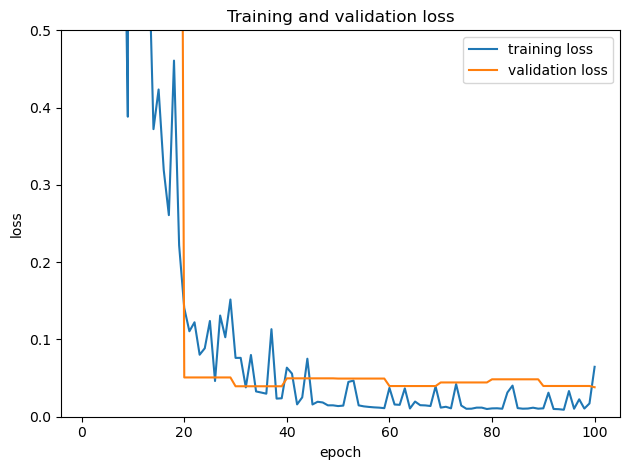

In [12]:
fig, ax = plt.subplots()
ax.plot(loss_df["epoch"], loss_df["training loss"], label="training loss")
ax.plot(loss_df["epoch"], loss_df["validation loss"], label="validation loss")
ax.set_ylim(ymin=0.0, ymax=0.5)
ax.set_xlabel("epoch")
ax.set_ylabel("loss")
ax.set_title("Training and validation loss")
ax.legend()
fig.tight_layout()

#### (3) Inference with all events

Upon concluding the training process, we extract the model's optimal parameters and apply
them to our entire test dataset—totaling $1.27 \times 10^8$ events, consisting of $9 \times 10^6$ signal
events and an overwhelming $1.18 \times 10^8$ background events.

CPU times: user 400 ms, sys: 190 ms, total: 589 ms
Wall time: 693 ms


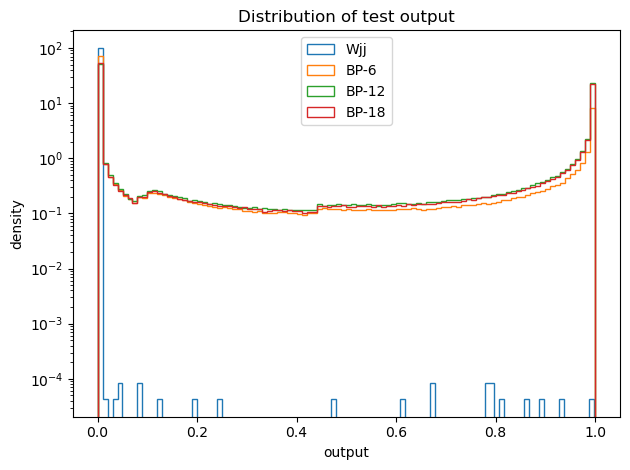

In [13]:
%%time
# CPU times: user 4min 52s, sys: 20.9 s, total: 5min 13s
# Wall time: 39.3 s

model_saved = Path.cwd() / f"diphoton_jets_cnn_{BATCH_SIZE}_{N_EPOCHS}.model"
test_output_saved = Path.cwd() / f"test_output_{BATCH_SIZE}_{N_EPOCHS}.npz"

if test_output_saved.exists():
    test_output = np.load(test_output_saved)

    params = dict(bins=100, density=True, histtype="step")

    fig, ax = plt.subplots()
    ax.hist(test_output["BG_Wjj"], **params, label="Wjj")
    ax.hist(test_output["BP-6"], **params, label="BP-6")
    ax.hist(test_output["BP-12"], **params, label="BP-12")
    ax.hist(test_output["BP-18"], **params, label="BP-18")
    ax.set_yscale("log")
    ax.set_xlabel("output")
    ax.set_ylabel("density")
    ax.set_title("Distribution of test output")
    ax.legend()
    fig.tight_layout()
else:
    test_output = None

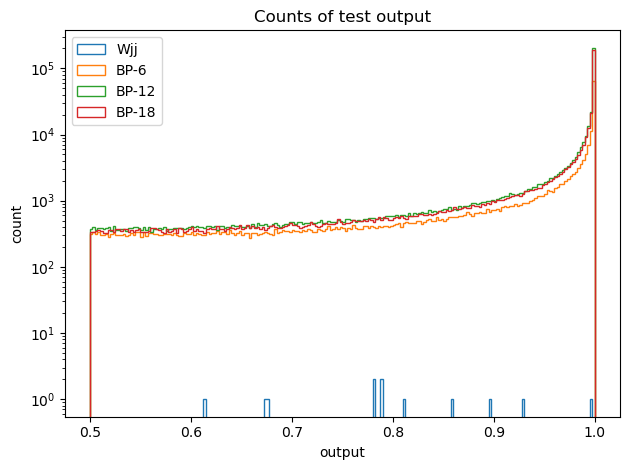

In [14]:
if test_output:
    params = dict(bins=200, density=False, range=[0.5, 1.0], histtype="step")

    fig, ax = plt.subplots()
    ax.hist(test_output["BG_Wjj"], **params, label="Wjj")
    ax.hist(test_output["BP-6"], **params, label="BP-6")
    ax.hist(test_output["BP-12"], **params, label="BP-12")
    ax.hist(test_output["BP-18"], **params, label="BP-18")
    ax.set_yscale("log")
    ax.set_xlabel("output")
    ax.set_ylabel("count")
    ax.set_title("Counts of test output")
    ax.legend()
    fig.tight_layout()

#### (4) Significance (Poisson-Poisson model with asymptotic formulae)

Subsequently, we apply a specified selection threshold $x_\text{cut}$ on the outputs of all the test samples.
Finally we then determine the comprehensive significance metric $\mathcal{S}$ in Equation 10.

__Reference__: https://cds.cern.ch/record/2736148/files/ATL-PHYS-PUB-2020-025.pdf (Section 4.4)

The recommened formula to use for estimating significance $S$ of observing $n$ events given a prediction of $b\pm\sigma$ events is:
$$
\mathcal{S} = \sqrt{2\Bigl( n\ln\Bigl[\frac{n(b+\sigma^2)}{b^2+n\sigma^2}\Bigr] - \frac{b^2}{\sigma^2}\ln\Bigl[1+\frac{\sigma^2(n-b)}{b(b+\sigma^2)}\Bigr] \Bigr)} \tag{10}
$$
where $n\geq b$. In the case of vanishing uncertainty ($\sigma=0$) this formula reduces to:
$$
\mathcal{S} = \sqrt{2\Bigl( n\ln\Bigl[\frac{n}{b}\Bigr] - (n-b) \Bigr)}
$$

In particular, we have
$$
\mathcal{S} = \sqrt{2\Bigl( n\ln\Bigl[\frac{n}{b}\Bigr] - \bigl(n+\tfrac{1}{\Delta^2}\bigr)\ln\Bigl[\frac{1+\Delta^2n}{1+\Delta^2b}\Bigr] \Bigr)}
$$
when $\sigma=\Delta b$ (e.g., $\Delta=0.1$). 

In [15]:
LUMINOSITY = 3_000

def significance(s: float, b: float, delta=0.1) -> float:
    if s == 0.:
        return 0.
    if b == 0.:
        return np.inf
    assert s > 0. and b > 0.
    
    s *= LUMINOSITY
    b *= LUMINOSITY

    n = s + b
    Z1 = n * np.log(n / b)
    delta2 = delta * delta
    Z2 = (n + 1. / delta2) * np.log((1. + delta2 * n) / (1. + delta2 * b))

    s = 2. * (Z1 - Z2)
    return np.sqrt(s) if s >= 0 else 0.

def calculate_signicance(test_output, threshold=0.5):
    test_counts = []
    for process_name in test_output:
        process_data = test_output[process_name]
        count = np.count_nonzero(
            np.where(process_data > threshold, 1, 0).squeeze()
        )
        test_counts.append([process_name, count, process_data.shape[0]])

    ml_cnn_df = pl.DataFrame(
        test_counts, schema=["process_name", "n_(mis)tagging", "n_bp_selection"]
    ).join(
        cutflow_df, on="process_name", how="inner"
    ).select(
        "process_name",
        "cross_section",
        "n_total_events",
        "n_(mis)tagging"
    )
    with pl.Config(tbl_rows=50, tbl_cols=20):
        print(ml_cnn_df)

    print(f"\nGiven the threshold option {threshold}, the signal significances for BP-6, BP-12, and BP-18 are as follows:")

    ml_cnn_cross_section_df = ml_cnn_df.select(
        "process_name",
        pl.all().exclude("process_name", "cross_section") \
            / pl.col("n_total_events") * pl.col("cross_section") * pl.lit(1_000.)
    )

    ml_cnn_total_bg_xs: np.ndarray = (ml_cnn_cross_section_df
        .filter(pl.col("process_name").str.starts_with("BG"))
        .select(pl.all().exclude("process_name").sum())
        .to_numpy().squeeze()
    )

    def ml_cnn_apply_significance(row, f):
        return tuple([row[0]] + [f(s, b) for s, b in zip(row[1:], ml_cnn_total_bg_xs)])

    ml_cnn_significance_df = (ml_cnn_cross_section_df
        .filter(pl.col("process_name").str.starts_with("BP"))
        .map_rows(lambda r: ml_cnn_apply_significance(r, significance))
        .rename({f"column_{i}": n for i, n in enumerate(ml_cnn_cross_section_df.columns)})
    )
    with pl.Config(tbl_rows=50, tbl_cols=20):
        print(ml_cnn_significance_df)

Given the threshold option, $x_\text{cut} = 0.5$, we present the signal significances
for BP-6, BP-12, and BP-18 as follows:

- $\mathcal{S}_\text{BP-6}^\text{10\%} = 9.0$, $\mathcal{S}_\text{BP-12}^\text{10\%} = 15.4$, $\mathcal{S}_\text{BP-18}^\text{10\%} = 15.0$

The outcomes from our CNN machine learning approach are indeed outstanding. Even with the
conservative threshold of $x_\text{cut} = 0.5$, BP-6 now reaches a significance of 9.0. Furthermore, both
BP-12 and BP-18 witness approximately 100% increases in their significances when compared to
the results from the cut-based analysis.

In [16]:
if test_output:
    calculate_signicance(test_output, threshold=0.5)

shape: (13, 4)
┌──────────────┬───────────────┬────────────────┬────────────────┐
│ process_name ┆ cross_section ┆ n_total_events ┆ n_(mis)tagging │
│ ---          ┆ ---           ┆ ---            ┆ ---            │
│ str          ┆ f64           ┆ i64            ┆ i64            │
╞══════════════╪═══════════════╪════════════════╪════════════════╡
│ BG_Wjj       ┆ 3560.517567   ┆ 100000000      ┆ 12             │
│ BG_Zjj       ┆ 267.930615    ┆ 10000000       ┆ 3              │
│ BG_tt        ┆ 123.073153    ┆ 1000000        ┆ 0              │
│ BG_WW        ┆ 82.143359     ┆ 1000000        ┆ 0              │
│ BG_WZ        ┆ 31.606161     ┆ 1000000        ┆ 0              │
│ BG_Wja       ┆ 25.477339     ┆ 1000000        ┆ 1              │
│ BG_ZZ        ┆ 11.7933       ┆ 1000000        ┆ 0              │
│ BG_Zja       ┆ 2.104376      ┆ 1000000        ┆ 0              │
│ BG_Waa       ┆ 0.032873      ┆ 1000000        ┆ 3              │
│ BG_Zaa       ┆ 0.011229      ┆ 1000000       

Opting for the more aggressive threshold of $x_\text{cut} = 0.9$
yields even more enhanced significances as follows:

- $\mathcal{S}_\text{BP-6}^\text{10\%} = 18.9$, $\mathcal{S}_\text{BP-12}^\text{10\%} = 33.2$, $\mathcal{S}_\text{BP-18}^\text{10\%} = 32.4$

Collectively, these outcomes emphatically demonstrate the effectiveness of our model architecture.

In [17]:
if test_output:
    calculate_signicance(test_output, threshold=0.9)

shape: (13, 4)
┌──────────────┬───────────────┬────────────────┬────────────────┐
│ process_name ┆ cross_section ┆ n_total_events ┆ n_(mis)tagging │
│ ---          ┆ ---           ┆ ---            ┆ ---            │
│ str          ┆ f64           ┆ i64            ┆ i64            │
╞══════════════╪═══════════════╪════════════════╪════════════════╡
│ BG_Wjj       ┆ 3560.517567   ┆ 100000000      ┆ 2              │
│ BG_Zjj       ┆ 267.930615    ┆ 10000000       ┆ 1              │
│ BG_tt        ┆ 123.073153    ┆ 1000000        ┆ 0              │
│ BG_WW        ┆ 82.143359     ┆ 1000000        ┆ 0              │
│ BG_WZ        ┆ 31.606161     ┆ 1000000        ┆ 0              │
│ BG_Wja       ┆ 25.477339     ┆ 1000000        ┆ 1              │
│ BG_ZZ        ┆ 11.7933       ┆ 1000000        ┆ 0              │
│ BG_Zja       ┆ 2.104376      ┆ 1000000        ┆ 0              │
│ BG_Waa       ┆ 0.032873      ┆ 1000000        ┆ 0              │
│ BG_Zaa       ┆ 0.011229      ┆ 1000000       